In [626]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

In [627]:
import numpy as np
from scipy.interpolate import CubicSpline

class ParametricCubicSpline:
    def __init__(self, t, points, bc_type='natural'):
        self.t = t
        self.points = points
         
        self.bc_type = bc_type
        self.spline_x = CubicSpline(t, points[:, 0], bc_type=bc_type)
        self.spline_y = CubicSpline(t, points[:, 1], bc_type=bc_type)
        
        self.coefficients_x = self.spline_x.c
        self.coefficients_y = self.spline_y.c

    def evaluate(self, t_val):
        x_val = self.spline_x(t_val)
        y_val = self.spline_y(t_val)
        return x_val, y_val

# Example usage:
t_values = np.linspace(0, 1, 4)  # Parameter values
control_points = np.array([[0, 0], [1, 3], [2, -1], [3, 2]])  # Control points

parametric_spline = ParametricCubicSpline(t_values, control_points)

In [628]:
t_fine = np.linspace(0, 1, 1000)

coordinates = np.array([parametric_spline.evaluate(t_val) for t_val in t_fine])

for i, coef in enumerate(parametric_spline.coefficients_x):
    print(f"Coefficients for segment {i}: {coef}")
    
for i, coef in enumerate(parametric_spline.coefficients_y):
    print(f"Coefficients for segment {i}: {coef}")

Coefficients for segment 0: [7.99360578e-15 0.00000000e+00 0.00000000e+00]
Coefficients for segment 1: [-2.66453526e-15 -2.66453526e-15  1.33226763e-15]
Coefficients for segment 2: [3. 3. 3.]
Coefficients for segment 3: [0. 1. 2.]
Coefficients for segment 0: [-63. 126. -63.]
Coefficients for segment 1: [  0. -63.  63.]
Coefficients for segment 2: [16. -5. -5.]
Coefficients for segment 3: [ 0.  3. -1.]


In [629]:
from random import randint
from sympy import *

a1,a2,a3,a4,b1,b2,b3,b4,x,y,s,ss,s1,s2,s3 = symbols('a1 a2 a3 a4 b1 b2 b3 b4 x y s s^* stilde_1 stilde_2 stilde_3')

In [630]:
fx = a1*s**3+a2*s**2+a3*s+a4
fy = b1*s**3+b2*s**2+b3*s+b4
D = (fx-x)**2 + (fy-y)**2

D_1 = diff(D,s)
D_2 = diff(D_1,s)

In [631]:
P = ((s - s2)*(s - s3))/((s1 - s2)*(s1 - s3))*D.subs(s, s1)+((s - s1)*(s - s3))/((s2 - s1)*(s2 - s3))*D.subs(s, s2)+((s - s1)*(s - s2))/((s3 - s1)*(s3 - s2))*D.subs(s, s3)
P_1 = diff(P, s)
approxD = solve(P_1,s)[0]


(a1**2*stilde_1**4*stilde_2/2 + a1**2*stilde_1**4*stilde_3/2 + a1**2*stilde_1**3*stilde_2**2/2 + a1**2*stilde_1**3*stilde_2*stilde_3 + a1**2*stilde_1**3*stilde_3**2/2 + a1**2*stilde_1**2*stilde_2**3/2 + a1**2*stilde_1**2*stilde_2**2*stilde_3 + a1**2*stilde_1**2*stilde_2*stilde_3**2 + a1**2*stilde_1**2*stilde_3**3/2 + a1**2*stilde_1*stilde_2**4/2 + a1**2*stilde_1*stilde_2**3*stilde_3 + a1**2*stilde_1*stilde_2**2*stilde_3**2 + a1**2*stilde_1*stilde_2*stilde_3**3 + a1**2*stilde_1*stilde_3**4/2 + a1**2*stilde_2**4*stilde_3/2 + a1**2*stilde_2**3*stilde_3**2/2 + a1**2*stilde_2**2*stilde_3**3/2 + a1**2*stilde_2*stilde_3**4/2 + a1*a2*stilde_1**3*stilde_2 + a1*a2*stilde_1**3*stilde_3 + a1*a2*stilde_1**2*stilde_2**2 + 2*a1*a2*stilde_1**2*stilde_2*stilde_3 + a1*a2*stilde_1**2*stilde_3**2 + a1*a2*stilde_1*stilde_2**3 + 2*a1*a2*stilde_1*stilde_2**2*stilde_3 + 2*a1*a2*stilde_1*stilde_2*stilde_3**2 + a1*a2*stilde_1*stilde_3**3 + a1*a2*stilde_2**3*stilde_3 + a1*a2*stilde_2**2*stilde_3**2 + a1*a2*stild

In [632]:
d = Function('d')(s)
Ptest = ((s - s2)*(s - s3))/((s1 - s2)*(s1 - s3))*d.subs(s, s1)+((s - s1)*(s - s3))/((s2 - s1)*(s2 - s3))*d.subs(s, s2)+((s - s1)*(s - s2))/((s3 - s1)*(s3 - s2))*d.subs(s, s3)
Ptest_1 = diff(Ptest, s)

testsol = solve(Ptest_1,s)
simplify(testsol[0])

(stilde_1**2*d(stilde_2) - stilde_1**2*d(stilde_3) - stilde_2**2*d(stilde_1) + stilde_2**2*d(stilde_3) + stilde_3**2*d(stilde_1) - stilde_3**2*d(stilde_2))/(2*(stilde_1*d(stilde_2) - stilde_1*d(stilde_3) - stilde_2*d(stilde_1) + stilde_2*d(stilde_3) + stilde_3*d(stilde_1) - stilde_3*d(stilde_2)))

In [633]:
simplify(D)

(a1*s**3 + a2*s**2 + a3*s + a4 - x)**2 + (b1*s**3 + b2*s**2 + b3*s + b4 - y)**2

In [634]:
simplify(D_1)

2*(3*a1*s**2 + 2*a2*s + a3)*(a1*s**3 + a2*s**2 + a3*s + a4 - x) + 2*(3*b1*s**2 + 2*b2*s + b3)*(b1*s**3 + b2*s**2 + b3*s + b4 - y)

In [635]:
simplify(D_2)

4*(3*a1*s + a2)*(a1*s**3 + a2*s**2 + a3*s + a4 - x) + 4*(3*b1*s + b2)*(b1*s**3 + b2*s**2 + b3*s + b4 - y) + 2*(3*a1*s**2 + 2*a2*s + a3)**2 + 2*(3*b1*s**2 + 2*b2*s + b3)**2

In [636]:
def newtonMethod(x0, iterationNumber, coeff_values):
    coeff_values['s'] = x0
    res = 2
    
    for i in range(iterationNumber):
        x1 = x0 - D_1.subs(coeff_values) / D_2.subs(coeff_values)
        coeff_values['s']= x1
     
        res = np.abs(x1 - x0)
        if res <= 0.000001:   # Stop when the result is within the desired tolerance
            return x1, res
        
        x0 = x1
    return x0, res


In [637]:
# Target point
target_point = np.array([0.9, 3.54])
coeff_values = {a1: 7.99360578e-15, a2: -2.66453526e-15, a3: 3, a4: 0, b1: -63, b2: 0, b3: 16, b4: 0, x: target_point[0], y: target_point[1], s: 0}

sol, res = newtonMethod(0.333, 100, coeff_values)
coeff_values = {a1: 8, a2: -2.66, a3: 3, a4: 0, b1: -63, b2: 0, b3: 16, b4: 0, x: target_point[0], y: target_point[1], s: sol}
coord_sol = parametric_spline.evaluate(sol)
print(sol, res, D.subs(coeff_values))

0.292381697475284 5.58525985239200e-7 0.193121258199906


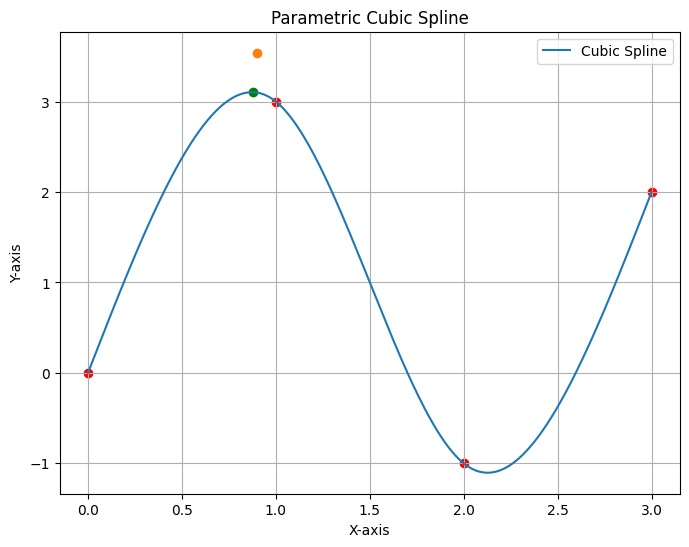

In [638]:
# Plot the original points and the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(coordinates[:,0], coordinates[:,1], label='Cubic Spline')
plt.plot(target_point[0], target_point[1], 'o')
plt.scatter(control_points[:, 0], control_points[:, 1], marker='o', color='red')
plt.scatter(coord_sol[0], coord_sol[1], marker='o', color='green')

plt.title('Parametric Cubic Spline')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()